In [11]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

lstm_preds = pd.read_csv("../results/lstm_predictions.csv")
transformer_preds = pd.read_csv("../results/transformer_predictions.csv")

metadata = pd.read_csv("../data/metadata.csv")


In [12]:
# merge gender information
lstm_preds = lstm_preds.merge(metadata[["filepath", "gender"]], on="filepath", how="left")
transformer_preds = transformer_preds.merge(metadata[["filepath", "gender"]], on="filepath", how="left")

lstm_preds.head(), transformer_preds.head()


(                                            filepath emotion gender_x  \
 0  ../data/RADVESS/Actor_02/03-01-05-01-02-01-02.wav   angry   female   
 1  ../data/RADVESS/Actor_20/03-01-05-01-01-01-20.wav   angry   female   
 2  ../data/RADVESS/Actor_09/03-01-04-01-02-02-09.wav     sad     male   
 3  ../data/RADVESS/Actor_15/03-01-03-02-01-01-15.wav   happy     male   
 4  ../data/RADVESS/Actor_05/03-01-05-02-02-01-05.wav   angry     male   
 
    emotion_label predicted gender_y  
 0              0       sad   female  
 1              0       sad   female  
 2              3       sad     male  
 3              1       sad     male  
 4              0       sad     male  ,
                                             filepath     true predicted  \
 0  ../data/RADVESS/Actor_22/03-01-05-02-01-01-22.wav    angry   neutral   
 1  ../data/RADVESS/Actor_24/03-01-03-02-01-01-24.wav    happy       sad   
 2  ../data/RADVESS/Actor_12/03-01-01-01-02-02-12.wav  neutral   neutral   
 3  ../data/RAD

In [13]:
# drop extra gener col
# Fix duplicate gender columns after merge
if "gender_y" in lstm_preds.columns:
    lstm_preds = lstm_preds.rename(columns={"gender_y": "gender"})
    lstm_preds = lstm_preds.drop(columns=["gender_x"], errors="ignore")

if "gender_y" in transformer_preds.columns:
    transformer_preds = transformer_preds.rename(columns={"gender_y": "gender"})
    transformer_preds = transformer_preds.drop(columns=["gender_x"], errors="ignore")

In [14]:
# --- STANDARDIZE TRUE LABELS ---
# LSTM uses "emotion" as the true label
if "emotion" in lstm_preds.columns:
    lstm_preds = lstm_preds.rename(columns={"emotion": "true"})

# Transformer uses "TRUE" as the true label
if "TRUE" in transformer_preds.columns:
    transformer_preds = transformer_preds.rename(columns={"TRUE": "true"})

# --- ENSURE 'gender' COLUMN EXISTS ---
# LSTM already contains gender
# Transformer must receive gender from earlier merge


In [15]:
# bia metric function
def compute_bias_metrics(df, model_name):
    results = []

    for gender in ["male", "female"]:
        subset = df[df["gender"] == gender]

        # Safety check: if no samples exist for gender, skip
        if len(subset) == 0:
            continue

        acc = accuracy_score(subset["true"], subset["predicted"])
        f1 = f1_score(subset["true"], subset["predicted"], average="weighted")

        results.append({
            "model": model_name,
            "gender": gender,
            "accuracy": acc,
            "f1_score": f1,
            "count": len(subset)
        })

    return pd.DataFrame(results)



In [16]:
# compute bias metrics
lstm_bias = compute_bias_metrics(lstm_preds, "LSTM")
transformer_bias = compute_bias_metrics(transformer_preds, "Transformer")

lstm_bias, transformer_bias



(  model  gender  accuracy  f1_score  count
 0  LSTM    male  0.285714  0.126984     70
 1  LSTM  female  0.292308  0.132234     65,
          model  gender  accuracy  f1_score  count
 0  Transformer    male  0.630769  0.630532     65
 1  Transformer  female  0.685714  0.683954     70)

In [17]:
# save bias metrics
lstm_bias.to_csv("../results/lstm_bias_metrics.csv", index=False)
transformer_bias.to_csv("../results/transformer_bias_metrics.csv", index=False)


In [18]:
# gender gap summary
summary = pd.DataFrame({
    "model": ["LSTM", "Transformer"],
    "accuracy_gap": [
        abs(lstm_bias.loc[lstm_bias.gender=="male","accuracy"].item() -
            lstm_bias.loc[lstm_bias.gender=="female","accuracy"].item()),
        abs(transformer_bias.loc[transformer_bias.gender=="male","accuracy"].item() -
            transformer_bias.loc[transformer_bias.gender=="female","accuracy"].item())
    ],
    "f1_gap": [
        abs(lstm_bias.loc[lstm_bias.gender=="male","f1_score"].item() -
            lstm_bias.loc[lstm_bias.gender=="female","f1_score"].item()),
        abs(transformer_bias.loc[transformer_bias.gender=="male","f1_score"].item() -
            transformer_bias.loc[transformer_bias.gender=="female","f1_score"].item())
    ]
})

summary.to_csv("../results/bias_summary.csv", index=False)
summary


,model,accuracy_gap,f1_gap
0,LSTM,0.006593,0.005250
1,Transformer,0.054945,0.053422


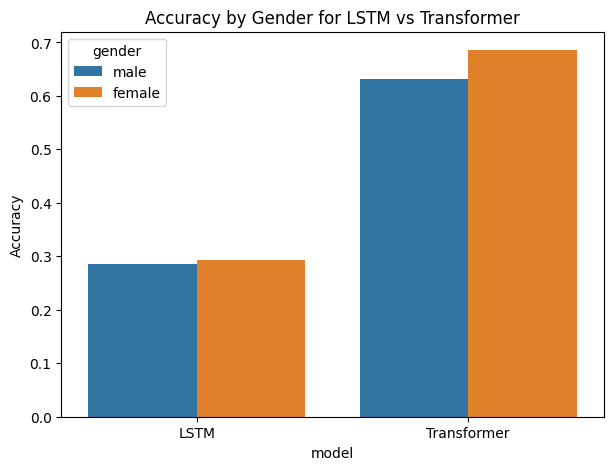

In [19]:
# gender accuracy plots
combined = pd.concat([lstm_bias, transformer_bias])

plt.figure(figsize=(7,5))
sns.barplot(data=combined, x="model", y="accuracy", hue="gender")
plt.title("Accuracy by Gender for LSTM vs Transformer")
plt.ylabel("Accuracy")
plt.savefig("../results/gender_gap_plot.png", dpi=300)
plt.show()


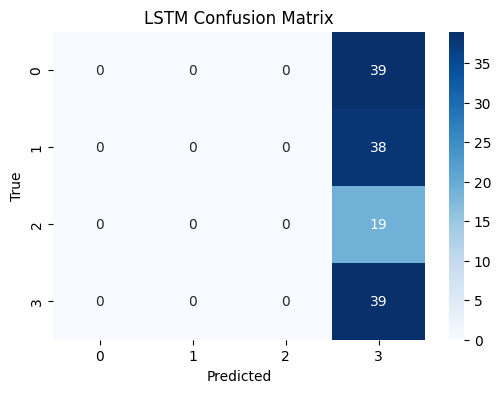

Saved: ../results/lstm_confusion_matrix.png


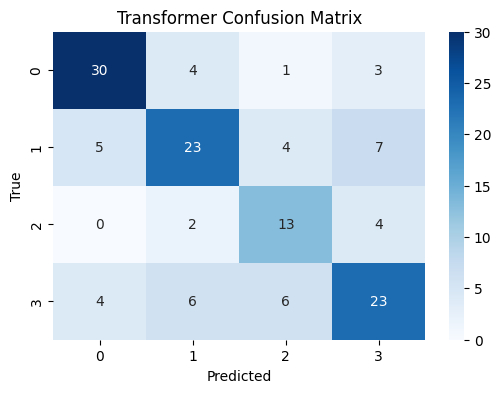

Saved: ../results/transformer_confusion_matrix.png


In [21]:
def plot_cm(df, model_name):
    cm = confusion_matrix(df["true"], df["predicted"])
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")

    # SAVE PNG
    save_path = f"../results/{model_name.lower()}_confusion_matrix.png"
    plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()
    print(f"Saved: {save_path}")

plot_cm(lstm_preds, "LSTM")
plot_cm(transformer_preds, "Transformer")
